https://github.com/int-brain-lab/iblvideo/blob/c25e7572153c87a90683021490e010ce55140a88/prototyping/motion_energy_pipeline.py

In [41]:
import os
import numpy as np
from one.api import ONE
import pickle
import pandas as pd
import matplotlib.pyplot as plt

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Functions/'
os.chdir(functions_path)
from video_functions import get_lick_times
from one_functions_generic import subjects_interest_data

### Get sessions from mice of interest

In [2]:
data_path =  '/home/ines/repositories/representation_learning_variability/Video/'
os.chdir(data_path)

mice = pickle.load(open("subject_intersection", "rb"))
naive_sessions = pickle.load(open("good_naive_sessions", "rb"))


/tmp/ipykernel_18377/540828854.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licks_df = licks_df.append(temp_df)
/tmp/ipykernel_18377/540828854.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licks_df = licks_df.append(temp_df)
/tmp/ipykernel_18377/540828854.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licks_df = licks_df.append(temp_df)
/tmp/ipykernel_18377/540828854.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licks_df = licks_df.append(temp_df)
/tmp/ipykernel_18377/540828854.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat in

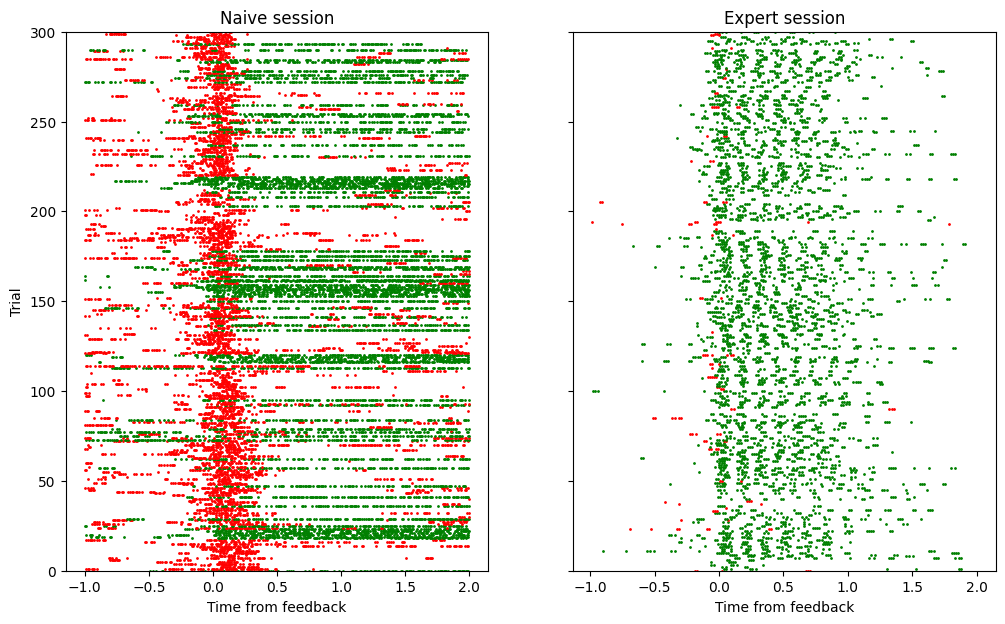

In [105]:
# Find paired sessions for each mouse
one = ONE()
for s, naive_session in enumerate(naive_sessions[7:8]):
    
    # Get mouse name
    session_details = one.list_datasets(naive_session, details=True)
    parts = session_details['session_path'][0].split('/')
    mouse_name = '/'.join(parts[2:3])
    
    # Get corresponding proficient sessions
    prof_sessions = subjects_interest_data([mouse_name], 'proficient', 'ephys')
    
    if len(prof_sessions) > 0:
        prof_sessions = prof_sessions['session'].unique()
        prof_session = prof_sessions[-1]

        # Get lick times for each of the sessions
        naive_lick_times = get_lick_times(naive_session, video_type = 'left')
        prof_lick_times = get_lick_times(prof_session, video_type = 'left')

        # Get trials for corresponding sessions
        
        trials_naive = one.load_object(naive_session, obj='trials', namespace='ibl')
        naive_df = trials_naive.to_df()
        
        trials_prof = one.load_object(prof_session, obj='trials', namespace='ibl')
        prof_df = trials_prof.to_df()
        
        
        licks_naive = psth(naive_df, naive_lick_times, 1, 2, event='feedback_times')
        licks_prof = psth(prof_df, prof_lick_times, 1, 2, event='feedback_times')

        # Plot data
        fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True, figsize=[12, 7])
        # Naive session
        data = licks_naive
        num_trials = int(np.max(data['trial']))
        # Plotting the spikes
        for t, trial in enumerate(range(num_trials)):
            licks_correct = np.array(data.loc[(data['trial']==t) & (data['correct']==1), 'lick_times'])
            licks_incorrect = np.array(data.loc[(data['trial']==t) & (data['correct']==-1), 'lick_times'])
            ax[0].scatter(licks_correct, np.full_like(licks_correct, t), color='green', s=1)
            ax[0].scatter(licks_incorrect, np.full_like(licks_incorrect, t), color='red', s=1)

        ax[0].set_title('Naive session')
        ax[0].set_xlabel('Time from feedback')
        ax[0].set_ylim([0, 300])

        # Prof session
        data = licks_prof
        num_trials = int(np.max(data['trial']))
        # Plotting the spikes
        for t, trial in enumerate(range(num_trials)):
            licks_correct = np.array(data.loc[(data['trial']==t) & (data['correct']==1), 'lick_times'])
            licks_incorrect = np.array(data.loc[(data['trial']==t) & (data['correct']==-1), 'lick_times'])
            ax[1].scatter(licks_correct, np.full_like(licks_correct, t), color='green', s=1)
            ax[1].scatter(licks_incorrect, np.full_like(licks_incorrect, t), color='red', s=1)
        ax[1].set_title('Expert session')
        ax[1].set_xlabel('Time from feedback')
        ax[0].set_ylabel('Trial')

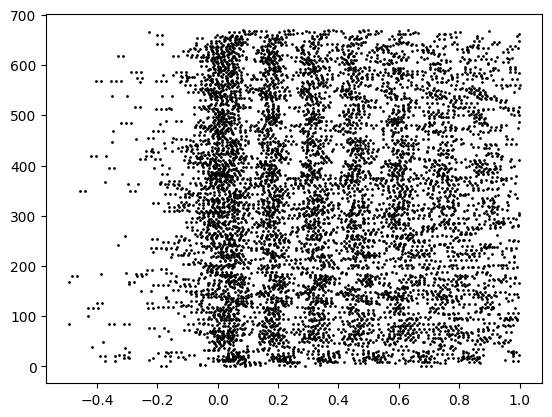

In [93]:
# Create a figure and axes
fig, ax = plt.subplots()
data = licks_prof

num_trials = int(np.max(data['trial']))
# Plotting the spikes
for t, trial in enumerate(range(num_trials)):
    licks = np.array(data.loc[data['trial']==t, 'lick_times'])
    ax.scatter(licks, np.full_like(licks, t), color='black', s=1)


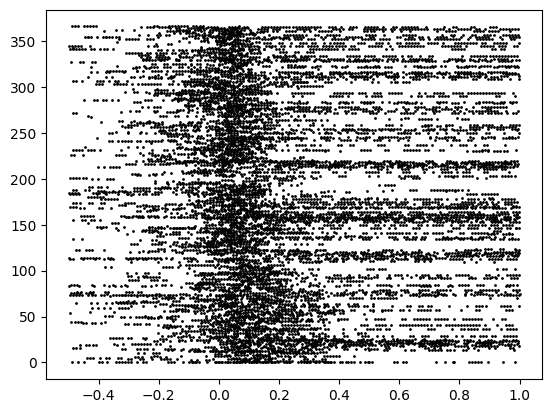

In [94]:
# Create a figure and axes
fig, ax = plt.subplots()
data = licks_naive

num_trials = int(np.max(data['trial']))
# Plotting the spikes
for t, trial in enumerate(range(num_trials)):
    licks = np.array(data.loc[data['trial']==t, 'lick_times'])
    ax.scatter(licks, np.full_like(licks, t), color='black', s=1)


In [102]:
def psth(trials, licks, t_init, t_end, event='feedback_times'):
    
    event_times = trials[event]
    feedback_type = trials['feedbackType']

    licks_df = pd.DataFrame(columns=['trial', 'lick_times', 'correct'])

    for t, trial in enumerate(event_times):
        event_time = event_times[t]
        correct = feedback_type[t]
        start = event_time - t_init
        end = event_time + t_end
        trial_licks = licks[(licks>start) & (licks<end)]
        aligned_lick_times = trial_licks - event_time
        
        # Temp dataframe
        temp_df = pd.DataFrame(columns=['trial', 'lick_times', 'correct'])
        temp_df['lick_times'] = aligned_lick_times
        temp_df['trial'] = np.ones(len(aligned_lick_times)) * t
        temp_df['correct'] = correct
        
        licks_df = licks_df.append(temp_df)
        
    return licks_df
    

### Get lick times

In [ ]:

'''
There should be one pqt file per camera, e.g. _ibl_leftCamera.features.pqt 
and it will contain columns named in Pascal case, 
the same way you would name an ALF attribute, e.g. pupilDiameter_raw and 
lick_times.
'''

one = ONE()    
eid = '572a95d1-39ca-42e1-8424-5c9ffcb2df87'


lick_times_left = get_lick_times(eid, video_type = 'left')
    
   

In [ ]:
# Check whether dlc and time data is available
# Naive sessions
eids = [UUID('fb9bdf18-76be-452b-ac4e-21d5de3a6f9f'),
       UUID('b117ed10-6871-42b3-9193-ca708dac4353'),
       UUID('db71a948-f414-4b44-afd6-45d45d127339'),
       UUID('895abba6-7ca1-44e7-b43f-e3cb43e850e7'),
       UUID('72578193-48bc-4c4c-a0c2-0954ae6f3b0c'),
       UUID('1aa50555-8acc-4fd5-b662-5206f3366f79'),
       UUID('b93a501c-3136-4129-a05f-ee47b90a6be7'),
       UUID('3271651b-33aa-4caf-9a23-1d813eb90593'),
       UUID('e00db9dd-b30a-4388-b7e2-7f54b342fc8d'),
       UUID('93ac89cc-89b8-4271-a40e-094b19d9fe78'),
       UUID('1ab810bb-1363-48a1-9a27-b6f9e56f95b1'),
       UUID('4c5702bf-01ca-4236-840d-9319a719f77f'),
       UUID('0bade8f5-fed5-49d0-ada9-ce310c8f4278'),
       UUID('34d2ab51-3a28-4d42-93b7-5d186bc57bbc'),
       UUID('9811969a-59f1-446a-bbdd-2b151f434097'),
       UUID('94fc857c-2332-419b-bf1b-110923355479'),
       UUID('34f045d9-e0c0-4dd4-82ed-98ce72afd8f5'),
       UUID('d67e094f-086f-48df-8d29-7c70614612a0'),
       UUID('dc990d49-4e51-4759-992b-292fbe22a7eb'),
       UUID('e7850826-9626-48d9-8a5a-e704bd9e6a5c'),
       UUID('6ecf1d29-4448-4332-b849-0764a856c2e3'),
       UUID('d7be2c7d-5dba-4083-9744-8c976e62fb43'),
       UUID('38bf926a-8e18-49db-8ee5-51f9fd0398f7'),
       UUID('e2c420b4-a23a-46aa-9ab5-1e82d6ffacc9'),
       UUID('69037c65-225f-4310-86f8-fdc3b9e35849'),
       UUID('8781d8bb-6ef4-4801-a82d-eb69b6009b48'),
       UUID('091fe0b7-138c-4f1f-9cd5-c4ffa275fb2f'),
       UUID('85da07f3-b1d4-439d-858d-5e0329a90b6f'),
       UUID('4ab187c7-a351-4bad-a6e8-dc5cdcac4196'),
       UUID('42a9949d-41c6-42ba-aee6-bc9fc0b5d728'),
       UUID('e777cadc-4d58-416f-b252-f80a31c02cca'),
       UUID('7ae52e2d-19d2-4983-8560-ce56fdcfee1c'),
       UUID('0f86be49-ca63-4134-8e36-1b29561abaaf'),
       UUID('953c20ee-0297-46b7-afdd-9af38a62d045'),
       UUID('8eaea787-11c0-46c0-aecd-80356be3d43c'),
       UUID('8a6557e8-5621-4ac8-a2dd-31070bdad530'),
       UUID('49816bfc-ef84-495c-a433-318ceac5addf'),
       UUID('28ed1dfe-70fe-497a-904c-c2e90c0e04d8'),
       UUID('58cbd4d5-f4bf-40cc-8049-69bfb3834c09'),
       UUID('6affae13-e348-4419-9284-7b159ff68b71'),
       UUID('7e63a637-bb3c-4183-88ce-0e19c04dce98'),
       UUID('a8fcf6a0-f836-4f1b-89f7-b7ccfad29469'),
       UUID('5706a188-0550-4c9f-94b1-01bfc36297e2'),
       UUID('0c3341af-b69b-4d88-bfdf-fbe2cffa31a6'),
       UUID('4c69dc31-872b-479b-b274-2ab5200750ac'),
       UUID('5d217d3f-0540-40b1-ad01-9b819ca3f504'),
       UUID('8fb5e960-91f2-4533-9df8-b18e480d9832'),
       UUID('68b55d66-85a5-40f6-802a-9b52d83f1b48'),
       UUID('41455345-12a1-4290-a279-78aa147d413f'),
       UUID('e4f3cbda-820e-434e-bca3-e995e710a2f6'),
       UUID('6bd1686f-8994-4f56-b8bb-972c006e100d'),
       UUID('c81e4e30-b8c8-4b9f-b91b-8409d35dbedb'),
       UUID('0604e90f-562d-459f-9c53-7a94a865fa0f'),
       UUID('e2e88cc1-906d-4617-9821-d4d74a7ce4bb'),
       UUID('1c258129-f19e-4cac-8759-f784c9398838'),
       UUID('f5841dbe-1632-4e9d-8014-90ac97083ddf'),
       UUID('6b06edc7-34cd-41c6-bdbd-a0459f9f41ee'),
       UUID('f728f886-5e41-44ed-b814-18b39ebeed13'),
       UUID('8f442320-5695-4473-9c8e-7d84c5809192'),
       UUID('ef4b2c9c-643a-4dec-877d-262acfa578f4'),
       UUID('16d65a8b-e725-4bff-b2e1-34cbf8deb42e'),
       UUID('8359b36d-e771-4fca-be89-54634ab3f6c5'),
       UUID('a8e094be-ba31-47b5-8fbc-7eb29753dbce'),
       UUID('af48b538-6f3e-4c8d-a74b-085f18934772'),
       UUID('4c23ce60-d7ef-4243-b1d4-091b794bbd7e'),
       UUID('a092dc80-ee28-4733-a4fb-beca52ead522'),
       UUID('32088c28-be54-4e32-9f8e-a03c4f85c6d0'),
       UUID('9c8e59c4-8476-4960-a764-f7cd9c554c33'),
       UUID('d642ea82-25cb-4f9b-83ae-27789ffc71d1'),
       UUID('80ad825a-4884-409d-bda4-34396268145e'),
       UUID('7af5c433-3113-4c94-b546-d7aef86ed520'),
       UUID('759a47ba-05df-43b7-a5fa-5b4f1a0fc680'),
       UUID('d5dc077d-c0de-4dbb-ba06-31cbb59962a8'),
       UUID('2977e871-1dbc-43aa-b0c7-42bb4dfd83f7'),
       UUID('3673cd1c-75fe-45b1-9844-9f76fdb656ed'),
       UUID('242ed7aa-6e02-4d55-b003-874b71357074'),
       UUID('8fcf6d86-687c-4f7e-b680-21c60e6186c7'),
       UUID('7331502c-ac8b-4d1c-ae35-b384e95088f4'),
       UUID('8780a43b-cf16-4620-882b-e8fa534b3159'),
       UUID('203ef696-0841-4b6f-9f02-fb25fc618e7c'),
       UUID('93d561f0-ca08-4042-a3ab-5db50dfb77e6'),
       UUID('e572b45a-34de-453a-b13e-4d90f0374f1e'),
       UUID('ed23d4ad-ec72-4b05-9feb-a1316368fc4d'),
       UUID('859b564e-2d77-4662-acf1-ea6c0d6af674'),
       UUID('0cade69a-dc14-4744-89ef-383151203e9b'),
       UUID('448e1454-01d6-4e51-ac45-9406d758a308'),
       UUID('5212f877-8db6-482e-a8f2-c084ca3f8f3b'),
       UUID('67851fb1-4977-47d8-85ab-741c4b9d3273'),
       UUID('b06a5faa-c1d2-48fb-a712-4672bf8f98e0'),
       UUID('5ffd032f-77c6-4e7b-a36b-84ce1f61c11f'),
       UUID('c3251068-9385-4490-ba69-25cd5f622e07'),
       UUID('7e26f9a4-e2fe-4831-ab79-12f58f960b2b'),
       UUID('25bbfae8-6e4d-4905-a788-89750ca694ae'),
       UUID('e3867a5f-300a-422f-9ba5-084c16a71551'),
       UUID('1d89f9a9-8953-44ad-b24c-fae00039f7a6'),
       UUID('83f34552-6f27-4b30-9293-5ffaf301657b'),
       UUID('7fbc5afb-d2b2-4fe2-8c7f-9a1b7aecd062'),
       UUID('2599b64e-247f-46e9-a753-5e64dac3e7f6'),
       UUID('e22f5286-c8b9-4ebf-9d80-7f0a69bd3dd4'),
       UUID('4a37104a-5d46-406f-8747-782615b4edbc'),
       UUID('76eff8f3-76db-4f2d-8715-f7e7bf23f49c'),
       UUID('07e992ee-2204-4bd4-83e3-fb3c15c751f0'),
       UUID('30666278-31be-455b-b091-f2758a1f6922'),
       UUID('84c6635d-9923-4ceb-825f-17ccc3aeaf28'),
       UUID('1076c0c0-ff1a-4634-8437-40dd3747bbc4'),
       UUID('de51b4a2-56f4-4925-b466-245d5170f039'),
       UUID('7cc60211-2b06-448f-8fc5-44eee2804fe9'),
       UUID('8f455fec-5f40-4cbb-9977-b4947a26cc1c'),
       UUID('c73dcf62-7bcf-4042-a4c0-d8e727129154'),
       UUID('978fae1e-24bd-4bc5-a6cf-207638a5b861'),
       UUID('8e1e8fd0-434d-422e-8a58-20c2aa002b83'),
       UUID('aa716244-94e7-45e4-98b8-4ba40430bff0'),
       UUID('b9ea8d04-b40e-4511-a12e-52b6115f1cd1'),
       UUID('cf5af157-8cd2-442b-802b-061b6af76242'),
       UUID('fd0910fe-144d-4953-b39a-7c769b9cd369'),
       UUID('ab231f2f-24b5-4ad5-921b-01cee946d557'),
       UUID('e391d5de-1181-42d3-af5a-eef18a94305e'),
       UUID('cece24d8-e37b-4e8d-ab59-c772c9a64f13'),
       UUID('0d6902bc-b72b-4ed9-bcee-892a56cc5fad'),
       UUID('d48f942e-54ff-44fb-869d-6c603adb9122'),
       UUID('4fc761a1-4fc0-485b-9ddd-786dcc48290b'),
       UUID('f0781d67-9de5-41ba-8f29-e7824523881d'),
       UUID('ef7be62b-d47a-4f31-b7f3-31e61d021c98'),
       UUID('f58f9783-618c-46b6-ae12-85e0883789ac'),
       UUID('b3003e96-5f81-4c28-a93c-fe4be773e7ef'),
       UUID('7188dbb7-145c-41d4-adcd-0c38d20bb5e0'),
       UUID('3ff8b912-5123-452a-9e28-3374ecc1115e'),
       UUID('00faade6-0576-41cc-8c01-a7737b0f60d0'),
       UUID('07c49f9d-0963-4d33-8e96-c2edb8079732'),
       UUID('f6d201cf-cfef-48dc-a0ab-cc9aa502ba8d'),
       UUID('538f60cb-2b90-4d1d-94cd-c282255bd1cd'),
       UUID('698e3c18-1e0e-4145-a975-16abdce92229'),
       UUID('f6652a78-8a1f-4e79-9f69-dc336ec50d93'),
       UUID('194f446c-ef22-423f-8de6-881af79d3a7f'),
       UUID('ce72efd3-444a-45ea-b591-3deb86a4e7be'),
       UUID('607ff49e-4b63-45ff-81f3-8492250ed112'),
       UUID('bbbea337-985e-47a9-99fa-b9ee7b645001'),
       UUID('a6cdd361-e742-4358-aacc-741e3f799fd2'),
       UUID('9b321fea-0127-48c6-9dba-baf9bf5fc094'),
       UUID('5a481d99-7532-47d0-aab5-8f055fb2a378'),
       UUID('1c581f5e-952a-48cd-b203-1901f02f77f7'),
       UUID('192e911a-86e3-4ca2-bc42-9c29085c28ad'),
       UUID('5d111796-040a-4bf8-b6d3-e3cac7a74c8d'),
       UUID('5e873c77-ba6c-4c00-887c-cc89d922fbce'),
       UUID('a903eb60-5909-45f1-b64b-ffcbedd4b679'),
       UUID('3adeafca-5a8b-49da-8cce-6dad741d24a8')]


In [34]:
good_eids = ['b117ed10-6871-42b3-9193-ca708dac4353', 
             '895abba6-7ca1-44e7-b43f-e3cb43e850e7', 
             '3271651b-33aa-4caf-9a23-1d813eb90593',
             '93ac89cc-89b8-4271-a40e-094b19d9fe78',
             '1ab810bb-1363-48a1-9a27-b6f9e56f95b1']
eid = '4c5702bf-01ca-4236-840d-9319a719f77f'  # naif
video_type = 'left'
query_type = 'remote'

lick_times_left = get_lick_times(eid, video_type = 'left')

ALFObjectNotFound: Dataset "alf/_ibl_leftCamera.times.npy" not found 
 The ALF object was not found.  This may occur if the object or namespace or incorrectly formatted e.g. the object "_ibl_trials.intervals.npy" would be found with the filters `object="trials", namespace="ibl"` 